# Optimal decision policies and induced feature distributions (Figure 1)

In this notebook we produce plots to qualitatively showcase how the feature distribution changes after the decision-maker publishes her policy to the individuals. The resulting plots are presented in Figure 1.

In [1]:
import os
os.chdir("../../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns
import networkx as nx
import itertools
import json
from lib import utils
sns.set_context("paper", font_scale=2)
np.random.seed(1)

In [3]:
locs = [(4,4),(7,10)]
u_peaks = [(0,3),(0,7)]
count = 2000
bins_count = 7
my_cmap = sns.cubehelix_palette(light=0.97, dark=0.3, as_cmap=True)
samples_all = []
utils_all = []
for loc in locs:
    sample = np.random.normal(loc,size=(count,2), scale=1)
    samples_all.extend(sample.tolist())
samples_all = np.array(samples_all)
H, xedges, yedges = np.histogram2d(samples_all[:,0], samples_all[:,1], bins=bins_count)

xedges = xedges[1:]
yedges = yedges[1:] 

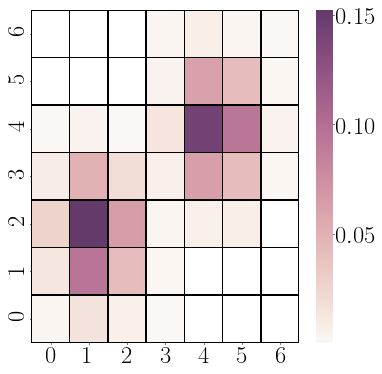

In [4]:
utils.latexify(6,6, font_scale=3.5)
den = H/H.sum()
sns.heatmap(den, cmap=my_cmap, mask=den==0,linewidths=.5,linecolor='black')
plt.gca().invert_yaxis()

In [5]:
yedges

array([ 2.72952919,  4.61241583,  6.49530248,  8.37818912, 10.26107576,
       12.1439624 , 14.02684904])

In [6]:
sample_x_index = []
for i in range(samples_all.shape[0]):
    lan = np.where(samples_all[i,0]<=(xedges))
    sample_x_index.append(lan[0][0] -1 if (lan[0][0]==xedges).sum()>0 else lan[0][0])
    
    
sample_y_index = []
for i in range(samples_all.shape[0]):
    lan = np.where(samples_all[i,1]<=(yedges))
    sample_y_index.append(lan[0][0] -1 if (lan[0][0]==yedges).sum()>0 else lan[0][0])
        
sample_x_index = np.array(sample_x_index)
sample_y_index = np.array(sample_y_index)


In [7]:
binn = bins_count
states = np.zeros(binn*binn)

In [8]:
for x,y in zip(sample_x_index, sample_y_index):
    states[x*binn+y]+=1
states = states/states.sum()

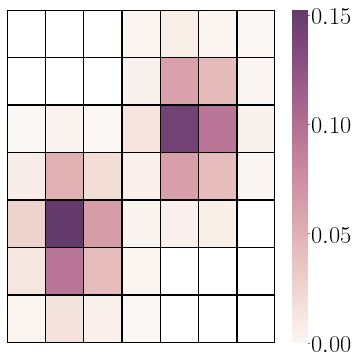

In [9]:
old_mass = states.reshape((binn,binn))
utils.latexify(6,6, font_scale=3.5)
sns.heatmap(old_mass, cmap=my_cmap, mask=den==0,linewidths=.5, linecolor='black', vmin=0, vmax=old_mass.max())
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/optimal/bour_px.pdf", dpi=300)

In [10]:
U = np.zeros(binn*binn)
for i in range(binn**2):
    y_1 = i%binn
    x_1 = i//binn
    for peak in u_peaks[:2]:
        U[i] += (binn-np.abs(peak[0]-x_1))+(binn-np.abs(peak[1]-y_1))

In [11]:
U=U-0.2

In [12]:
U = (U-U.min())
U = U/U.max()

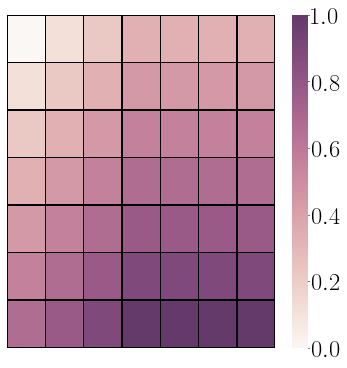

In [13]:
utils.latexify(6,6, font_scale=3.5)
ax = sns.heatmap(np.reshape(U, (binn,binn)), cmap=my_cmap,linewidths=.5,linecolor='black', vmin=0, vmax=U.max())
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/optimal/bour_u.pdf", dpi=300)

## Induced distributions for different values of $\alpha$.

The following code produces the figures of the induced distribution for various values of the parameter $\alpha$ representing the ability of individuals to move from one feature value to another. The value of $\alpha$ can be set at the following box. The figures in the paper are produced with $\alpha=0.1, 0.5, 1.1$.

In [14]:
# alpha = 1.1
# alpha = 0.5
alpha = 0.1

In [15]:
C = np.zeros((binn*binn, binn*binn))

In [16]:
for i in range(binn**2):
    for j in range(binn**2):
        y_1 = i%binn
        x_1 = i//binn
        
        y_2 = j%binn
        x_2 = j//binn
        
        dist = np.abs(x_1 - x_2)+np.abs(y_1 - y_2)
        C[i,j] = dist
        
C=C*alpha

In [17]:
%load_ext autoreload
%autoreload 2
from lib import iterative

In [18]:
indexing = np.zeros(binn*binn,dtype=int)
ind = 0
for i in sorted(range(binn),reverse=True):
    for j in range(binn):
        indexing[ind] = i*binn + j
        ind += 1

In [19]:
u_df = pd.DataFrame(data={'Probability': U}, index=indexing)
u_df.sort_values(by=["Probability"],inplace=True, ascending=False)
new_indexing=u_df.index.values.flatten().tolist()
new_u = u_df.values.flatten()

px_df = pd.DataFrame(data=states, index=indexing)
new_px = px_df.reindex(new_indexing).to_numpy().flatten()

c_df = pd.DataFrame(C, index=indexing, columns=indexing)
new_c=c_df[new_indexing]
new_c = new_c.reindex(new_indexing).to_numpy()

In [20]:
attr = iterative.compute_iter("./outputs/optimal/bour_alpha_{alpha}".format(alpha=alpha), new_c, new_u, new_px, seed=1, alpha=alpha, indexing=new_indexing)

Iterative RunTime = 0.22064900398254395
Final Utility = 0.9999999999999999


In [21]:
with open("./outputs/optimal/bour_alpha_{alpha}_config.json".format(alpha=alpha), 'r') as f:
    results = json.load(f)

In [22]:
final_pi = np.zeros(binn*binn)
for ind,i in enumerate(indexing):
    final_pi[ind] = results['pi'][str(i)]
final_pi = np.reshape(final_pi, (binn,binn))

trans_matrix = np.zeros((binn**2,binn**2),dtype=int)
new_mass = np.zeros(binn*binn)
for enum,i in enumerate(indexing):
    br = results['strategic_br'][str(i)]
    ind = np.where(indexing==br)[0]
    new_mass[ind] += px_df.loc[i]
    trans_matrix[enum,ind] = 1
new_mass = np.reshape(new_mass, (binn,binn))

In [23]:
nodes__= list(itertools.product(range(binn),range(binn)))
nodes = [(i[0]+0.5,binn-i[1]+0.5) for i in nodes__]

In [24]:
Q = trans_matrix

In [25]:
G = nx.MultiDiGraph()
labels={}
edge_labels={}

for i, origin_state in enumerate(nodes):
    for j, destination_state in enumerate(nodes):
        rate = Q[i][j]
        
        #print(origin_state, destination_state, rate)
        if rate > 0 and (states[i]>0):
            G.add_edge(origin_state,
                       destination_state,
                       weight=rate,
                       label="{:.02f}".format(rate))
            edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)

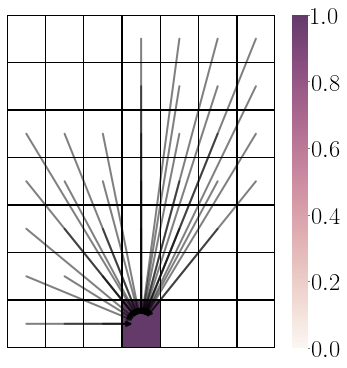

In [26]:
utils.latexify(6,6, font_scale=3.5)
node_size = 200
pos = {node:[binn-node[1]+1,node[0]] for node in nodes}
nx.draw_networkx_edges(G,pos,width=2.0,alpha=0.5)

plt.axis('off');
sns.heatmap(new_mass, cmap=my_cmap,linewidths=.5,linecolor='black',mask=new_mass==0, vmin=0, vmax=new_mass.max())
plt.gca().invert_yaxis()
plt.savefig("./figures/optimal/bour_final_mass_{alpha}.pdf".format(alpha=str(alpha).replace(".","_")), dpi=300)

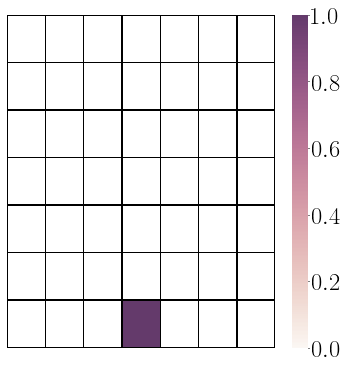

In [27]:
utils.latexify(6,6, font_scale=3.5)
sns.heatmap(final_pi, cmap=my_cmap,linewidths=.5,linecolor='black',mask=new_mass==0, vmin=0, vmax=1)
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/optimal/bour_pi_{alpha}.pdf".format(alpha=str(alpha).replace(".","_")), dpi=300)